# Tarea N°3: Clustering de Establecimientos Hospitalarios
## Análisis de Agrupamiento de Hospitales Públicos de Chile

**Alumno:** Miguel Espinoza  
**Profesor:** Ana Aguilera Faraco  
**Ayudante:** Fernanda Fuentes  
**Fecha:** Octubre 2025

---

## Objetivo

Aplicar técnicas de clustering para agrupar establecimientos hospitalarios públicos de Chile según sus características operativas, niveles de ocupación y patrones de atención, identificando similitudes, diferencias y posibles tipologías de funcionamiento.

## 1. Importar Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print('Librerías importadas correctamente')

## 2. Cargar y Explorar los Datos

In [ ]:
# Cargar el dataset
df = pd.read_csv(
    'indicadores_rem20_20251025.csv', 
    sep=';', 
    encoding='utf-8', 
    on_bad_lines='skip',
    low_memory=False
)

print(f'Forma del dataset: {df.shape}')
print(f'\nPrimeras filas:')
df.head()

In [ ]:
# Información del dataset
print('Información del dataset:')
df.info()

print(f'\nTipos de datos:')
print(df.dtypes)

In [ ]:
# Estadísticas descriptivas
print('Estadísticas descriptivas:')
df.describe()

In [ ]:
# Verificar valores faltantes
print('Valores faltantes por columna:')
print(df.isnull().sum())

print(f'\nPorcentaje de valores faltantes:')
print((df.isnull().sum() / len(df) * 100).round(2))

In [ ]:
# Nombres de columnas
print('Columnas disponibles:')
for i, col in enumerate(df.columns, 1):
    print(f'{i}. {col}')

## 3. Preprocesamiento de Datos

In [ ]:
# Preprocesamiento de datos
df_procesado = df.copy()

# Rellenar valores faltantes con la media en columnas numéricas
numeric_cols = df_procesado.select_dtypes(include=[np.number]).columns
df_procesado[numeric_cols] = df_procesado[numeric_cols].fillna(df_procesado[numeric_cols].mean())

print(f'Forma del dataset: {df_procesado.shape}')
print(f'Valores faltantes: {df_procesado.isnull().sum().sum()}')

In [ ]:
# Seleccionar columnas numéricas para clustering
columnas_numericas = df_procesado.select_dtypes(include=[np.number]).columns
print(f'Columnas numéricas para clustering: {len(columnas_numericas)}')
print(columnas_numericas.tolist())

# Crear matriz de características
X = df_procesado[columnas_numericas].copy()

# Verificar nuevamente valores faltantes
print(f'\nValores faltantes en matriz X: {X.isnull().sum().sum()}')

In [ ]:
# Normalizar/Estandarizar los datos
scaler = StandardScaler()
X_escalado = scaler.fit_transform(X)

# Convertir a DataFrame para facilitar manipulación
X_escalado_df = pd.DataFrame(X_escalado, columns=X.columns)

print('Datos escalados:')
print(f'Media: {X_escalado_df.mean().round(2)}')
print(f'Desviación estándar: {X_escalado_df.std().round(2)}')

In [96]:
# Crear muestra consistente para todo el análisis
print('Creando muestra consistente para todo el análisis...')

# Tamaño de muestra (20% del dataset)
sample_size = max(10000, int(len(X_escalado) * 0.20))
np.random.seed(42)
sample_indices = np.random.choice(len(X_escalado), sample_size, replace=False)

# Muestra escalada
X_muestra_escalada = X_escalado[sample_indices]
df_muestra = df_procesado.iloc[sample_indices].copy()

print(f'Tamaño de dataset completo: {len(X_escalado):,} registros')
print(f'Tamaño de muestra: {len(X_muestra_escalada):,} registros ({len(X_muestra_escalada)/len(X_escalado)*100:.1f}%)')
print(f'\nEsta muestra será utilizada CONSISTENTEMENTE en:')
print(f'  • Elbow Method (Silhouette Score)')
print(f'  • K-Means training')
print(f'  • Clustering Jerárquico')
print(f'  • PCA y visualizaciones')
print(f'  • Todas las métricas y análisis')

Creando muestra consistente para todo el análisis...
Tamaño de dataset completo: 156,453 registros
Tamaño de muestra: 31,290 registros (20.0%)

Esta muestra será utilizada CONSISTENTEMENTE en:
  • Elbow Method (Silhouette Score)
  • K-Means training
  • Clustering Jerárquico
  • PCA y visualizaciones
  • Todas las métricas y análisis


## 4. Determinar el Número Óptimo de Clusters

Calculando Elbow Method en muestra consistente...


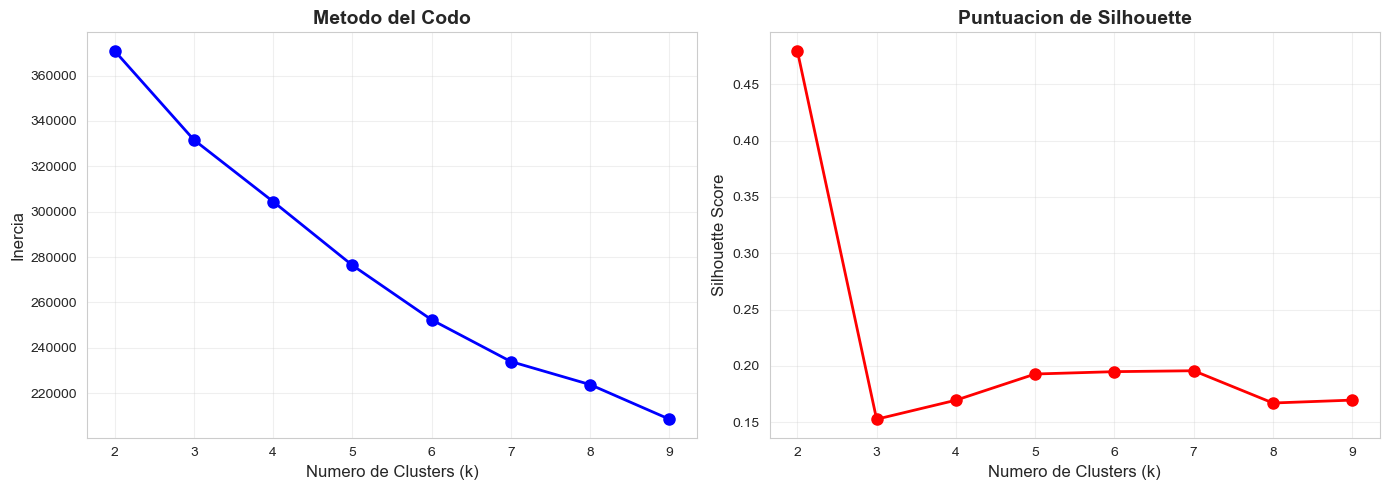

Silhouette Scores para diferentes k:
k=2: 0.4798
k=3: 0.1527
k=4: 0.1696
k=5: 0.1928
k=6: 0.1949
k=7: 0.1957
k=8: 0.1671
k=9: 0.1697


In [97]:
# Metodo del Codo (Elbow Method)
print('Calculando Elbow Method en muestra consistente...')
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    # Entrenar en muestra
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_muestra_escalada)
    inertias.append(kmeans.inertia_)
    
    # Calcular Silhouette en la misma muestra
    silhouette_scores.append(silhouette_score(X_muestra_escalada, kmeans.labels_))

# Visualizar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Grafico del Codo
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Numero de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inercia', fontsize=12)
ax1.set_title('Metodo del Codo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Grafico del Silhouette
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Numero de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Puntuacion de Silhouette', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Silhouette Scores para diferentes k:')
for k, score in zip(K_range, silhouette_scores):
    print(f'k={k}: {score:.4f}')

## 5. Aplicar Algoritmo K-Means

In [98]:
# Aplicar K-Means con numero optimo de clusters
k_optimo = 3

print(f'Entrenando K-Means en muestra consistente...')
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters_kmeans_muestra = kmeans.fit_predict(X_muestra_escalada)

# Predecir clusters en el dataset COMPLETO usando el modelo entrenado
clusters_kmeans_full = kmeans.predict(X_escalado)

# Agregar etiquetas al dataframe
df_procesado['Cluster_KMeans'] = clusters_kmeans_full
df_muestra['Cluster_KMeans'] = clusters_kmeans_muestra

print(f'Clusters K-Means asignados: {np.unique(clusters_kmeans_muestra)}')
print(f'\nDistribucion de clusters (muestra):')
print(df_muestra['Cluster_KMeans'].value_counts().sort_index())
print(f'\nDistribucion de clusters (dataset completo):')
print(df_procesado['Cluster_KMeans'].value_counts().sort_index())

# Metricas de evaluacion en muestra
print(f'\nMetricas de evaluacion K-Means (en muestra):')
print(f'Silhouette Score: {silhouette_score(X_muestra_escalada, clusters_kmeans_muestra):.4f}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(X_muestra_escalada, clusters_kmeans_muestra):.4f}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(X_muestra_escalada, clusters_kmeans_muestra):.4f}')

Entrenando K-Means en muestra consistente...
Clusters K-Means asignados: [0 1 2]

Distribucion de clusters (muestra):
Cluster_KMeans
0    13274
1     2446
2    15570
Name: count, dtype: int64

Distribucion de clusters (dataset completo):
Cluster_KMeans
0    66419
1    12212
2    77822
Name: count, dtype: int64

Metricas de evaluacion K-Means (en muestra):
Clusters K-Means asignados: [0 1 2]

Distribucion de clusters (muestra):
Cluster_KMeans
0    13274
1     2446
2    15570
Name: count, dtype: int64

Distribucion de clusters (dataset completo):
Cluster_KMeans
0    66419
1    12212
2    77822
Name: count, dtype: int64

Metricas de evaluacion K-Means (en muestra):
Silhouette Score: 0.1527
Davies-Bouldin Index: 1.8253
Calinski-Harabasz Index: 6782.3409
Silhouette Score: 0.1527
Davies-Bouldin Index: 1.8253
Calinski-Harabasz Index: 6782.3409


## 6. Análisis de Clusters

In [99]:
# Analisis descriptivo por cluster (en muestra)
print('CARACTERISTICAS PROMEDIO POR CLUSTER (en muestra consistente):\n')

for cluster in range(k_optimo):
    print(f'\nCLUSTER {cluster}')
    cluster_mask = df_muestra['Cluster_KMeans'] == cluster
    print(f'Cantidad de registros en muestra: {cluster_mask.sum()}')
    
    cluster_data = df_muestra[cluster_mask][columnas_numericas]
    print(f'Promedio de caracteristicas:')
    print(cluster_data.mean().round(2))

CARACTERISTICAS PROMEDIO POR CLUSTER (en muestra consistente):


CLUSTER 0
Cantidad de registros en muestra: 13274
Promedio de caracteristicas:
PERIODO                        2019.51
TIPO_PERTENENCIA                  1.00
COD_SSS                          22.02
CODIGO_ESTABLECIMIENTO       122647.63
COD_AREA_FUNCIONAL              404.19
MES                               6.43
DIAS_CAMAS_OCUPADAS             226.31
DIAS_CAMAS_DISPONIBLES          364.81
DIAS_ESTADA                     216.75
NUMERO_EGRESOS                   37.36
EGRESOS_FALLECIDOS                0.82
TRASLADOS                         5.22
INDICE_OCUPACIONAL               50.24
PROMEDIO_CAMAS_DISPONIBLE        11.99
PROMEDIO_DIAS_ESTADA              9.88
LETALIDAD                         3.45
INDICE_ROTACION                   2.67
dtype: float64

CLUSTER 1
Cantidad de registros en muestra: 2446
Promedio de caracteristicas:
PERIODO                        2019.58
TIPO_PERTENENCIA                  1.00
COD_SSS              

Creando heatmap de características por cluster (muestra)...



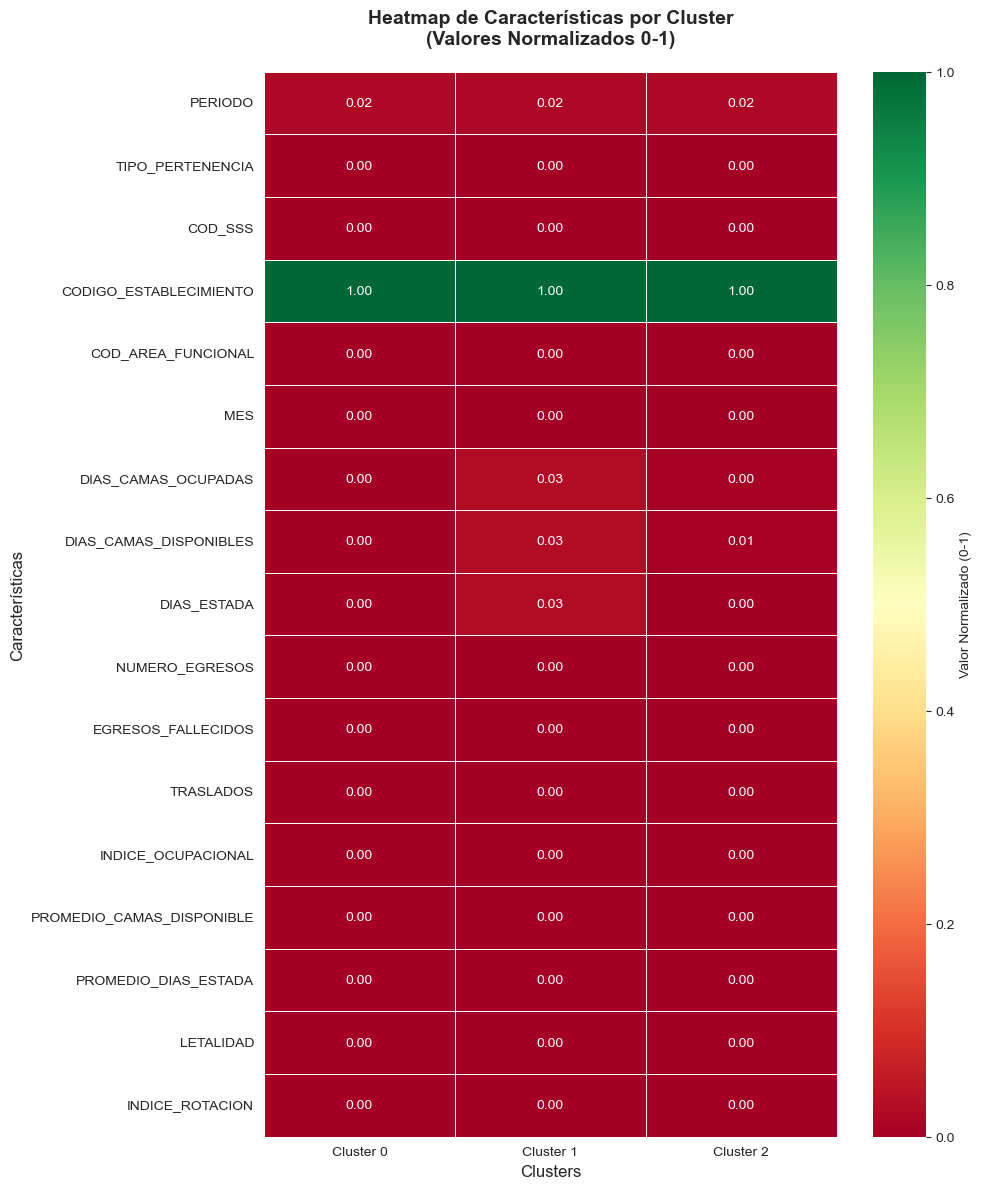

Heatmap completado.


In [100]:
# Heatmap de características por cluster (muestra consistente)
print('Creando heatmap de características por cluster (muestra)...\n')

# Calcular promedios por cluster en la muestra
cluster_profiles = []
for cluster in range(k_optimo):
    cluster_mask = df_muestra['Cluster_KMeans'] == cluster
    cluster_data = df_muestra[cluster_mask][columnas_numericas]
    cluster_profiles.append(cluster_data.mean())

# Crear DataFrame con perfiles de clusters
profile_df = pd.DataFrame(cluster_profiles).T
profile_df.columns = [f'Cluster {i}' for i in range(k_optimo)]

# Normalizar para visualización (escala 0-1)
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
profile_normalized = pd.DataFrame(
    scaler_viz.fit_transform(profile_df),
    index=profile_df.index,
    columns=profile_df.columns
)

# Crear heatmap
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(profile_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Valor Normalizado (0-1)'}, ax=ax, linewidths=0.5)
ax.set_title('Heatmap de Características por Cluster\n(Valores Normalizados 0-1)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Características', fontsize=12)
ax.set_xlabel('Clusters', fontsize=12)
plt.tight_layout()
plt.show()

print('Heatmap completado.')

In [101]:
# Análisis de dispersión estadística por cluster (muestra)
print('ANALISIS DE DISPERSIÓN ESTADÍSTICA POR CLUSTER (en muestra)')
print('='*80)

for cluster in range(k_optimo):
    cluster_mask = df_muestra['Cluster_KMeans'] == cluster
    cluster_data = df_muestra[cluster_mask][columnas_numericas]
    
    print(f'\n{"─"*80}')
    print(f'CLUSTER {cluster} - {cluster_mask.sum()} registros en muestra ({cluster_mask.sum()/len(df_muestra)*100:.1f}%)')
    print(f'{"─"*80}')
    
    # Crear tabla de estadísticas
    stats_data = {
        'Caracteristica': columnas_numericas,
        'Media': cluster_data.mean().values,
        'Desv.Est': cluster_data.std().values,
        'Min': cluster_data.min().values,
        'Q25': cluster_data.quantile(0.25).values,
        'Mediana': cluster_data.median().values,
        'Q75': cluster_data.quantile(0.75).values,
        'Max': cluster_data.max().values
    }
    
    stats_df = pd.DataFrame(stats_data)
    stats_df = stats_df.round(2)
    
    print(stats_df.to_string(index=False))
    
    # Análisis de homogeneidad
    cv = (cluster_data.std() / cluster_data.mean().abs()).mean()  # Coef. Variación promedio
    print(f'\nCoeficiente de Variación Promedio: {cv:.2f}')
    if cv < 0.5:
        print('  → Cluster HOMOGENEO (baja dispersión)')
    elif cv < 1.0:
        print('  → Cluster MODERADAMENTE HOMOGENEO')
    else:
        print('  → Cluster HETEROGENEO (alta dispersión)')

print(f'\n{"="*80}')
print('Análisis de dispersión completado.')

ANALISIS DE DISPERSIÓN ESTADÍSTICA POR CLUSTER (en muestra)

────────────────────────────────────────────────────────────────────────────────
CLUSTER 0 - 13274 registros en muestra (42.4%)
────────────────────────────────────────────────────────────────────────────────
           Caracteristica     Media  Desv.Est      Min       Q25   Mediana       Q75       Max
                  PERIODO   2019.51      3.32   2014.0   2017.00   2020.00   2022.00   2025.00
         TIPO_PERTENENCIA      1.00      0.00      1.0      1.00      1.00      1.00      1.00
                  COD_SSS     22.02      5.09      2.0     18.00     21.00     25.00     33.00
   CODIGO_ESTABLECIMIENTO 122647.63   7898.54 111100.0 118106.00 121121.00 125101.00 201319.00
       COD_AREA_FUNCIONAL    404.19     20.72    330.0    403.00    407.00    414.00    429.00
                      MES      6.43      3.44      1.0      3.00      6.00      9.00     12.00
      DIAS_CAMAS_OCUPADAS    226.31    276.80      0.0     32.00 

Aplicando PCA en muestra...


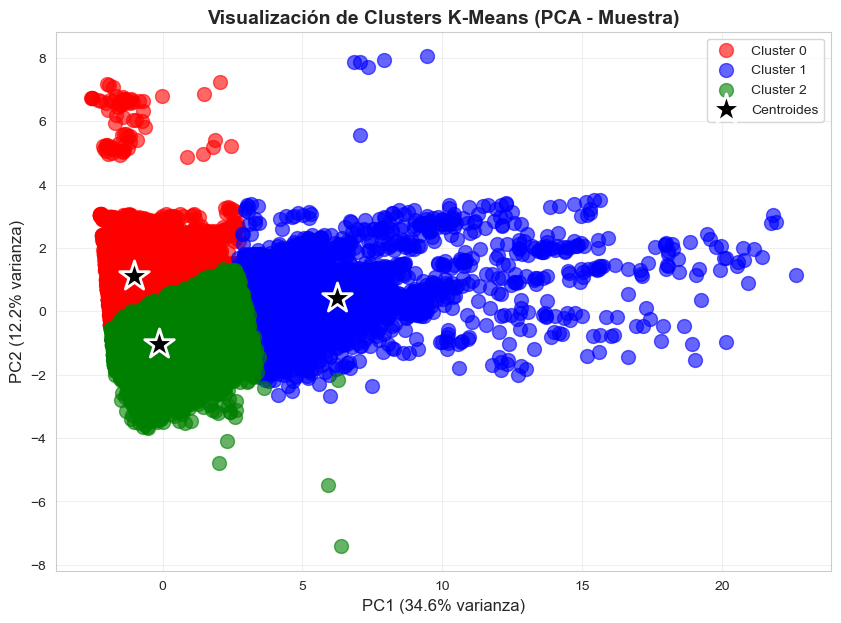

Varianza explicada acumulada: 46.8%


In [102]:
# Visualizar distribución de clusters (usando PCA - muestra consistente)
from sklearn.decomposition import PCA

print('Aplicando PCA en muestra...')
# Aplicar PCA en muestra
pca = PCA(n_components=2)
X_pca_muestra = pca.fit_transform(X_muestra_escalada)

# Gráfico de clusters
plt.figure(figsize=(10, 7))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for cluster in range(k_optimo):
    mask = clusters_kmeans_muestra == cluster
    plt.scatter(X_pca_muestra[mask, 0], X_pca_muestra[mask, 1], 
               label=f'Cluster {cluster}', 
               s=100, alpha=0.6,
               color=colors[cluster % len(colors)])

# Plotear centroides en espacio PCA
centroides_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], 
           marker='*', s=500, c='black', edgecolors='white', linewidth=2,
           label='Centroides')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)', fontsize=12)
plt.title('Visualización de Clusters K-Means (PCA - Muestra)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print(f'Varianza explicada acumulada: {pca.explained_variance_ratio_.sum():.1%}')

## 7. Clustering Jerárquico (Opcional)

In [2]:
# Aplicar clustering jerarquico en la muestra consistente
from sklearn.cluster import AgglomerativeClustering
print(f'Aplicando clustering jerarquico en muestra consistente...')

agg_clustering = AgglomerativeClustering(n_clusters=k_optimo, linkage='ward')
clusters_hierarchical_muestra = agg_clustering.fit_predict(X_muestra_escalada)

print(f'Metricas Clustering Jerarquico (muestra consistente):')
print(f'Silhouette Score: {silhouette_score(X_muestra_escalada, clusters_hierarchical_muestra):.4f}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(X_muestra_escalada, clusters_hierarchical_muestra):.4f}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(X_muestra_escalada, clusters_hierarchical_muestra):.4f}')

print(f'\nDistribucion de clusters jerarquicos:')
unique, counts = np.unique(clusters_hierarchical_muestra, return_counts=True)
for u, c in zip(unique, counts):
    print(f'Cluster {u}: {c} registros')

Aplicando clustering jerarquico en muestra consistente...


NameError: name 'k_optimo' is not defined

In [ ]:
# Dendrograma (usar muestra pequeña de la muestra consistente)
from scipy.cluster.hierarchy import dendrogram, linkage

# Limitar a una muestra muy pequeña para visualización (de la muestra)
print(f'Creando dendrograma con muestra de visualización...\n')

dendro_sample_size = min(30, len(X_muestra_escalada))
dendro_indices = np.random.choice(len(X_muestra_escalada), dendro_sample_size, replace=False)
X_dendro_sample = X_muestra_escalada[dendro_indices]

Z = linkage(X_dendro_sample, method='ward')

plt.figure(figsize=(14, 7))
dendrogram(Z)
plt.title('Dendrograma - Clustering Jerárquico (Muestra de Visualización)', fontsize=14, fontweight='bold')
plt.xlabel('Índice del Registro', fontsize=12)
plt.ylabel('Distancia', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print('Dendrograma completado.')

## 8. Comparación de Resultados

In [ ]:
# Comparar resultados (ambos en muestra consistente)
print('Comparacion de algoritmos de clustering (en muestra consistente):\n')

algorithms = {
    'K-Means': clusters_kmeans_muestra,
    'Clustering Jerarquico': clusters_hierarchical_muestra
}

for name, clusters in algorithms.items():
    print(f'{name}:')
    print(f'  Silhouette Score: {silhouette_score(X_muestra_escalada, clusters):.4f}')
    print(f'  Davies-Bouldin Index: {davies_bouldin_score(X_muestra_escalada, clusters):.4f}')
    print(f'  Calinski-Harabasz Index: {calinski_harabasz_score(X_muestra_escalada, clusters):.4f}')
    print()

In [ ]:
# Interpretación narrativa de clusters (basado en muestra)
print('INTERPRETACIÓN NARRATIVA DE LOS CLUSTERS (muestra consistente)')
print('='*80)

for cluster in range(k_optimo):
    cluster_mask = df_muestra['Cluster_KMeans'] == cluster
    cluster_data = df_muestra[cluster_mask][columnas_numericas]
    means = cluster_data.mean()
    
    # Calcular percentiles respecto a la muestra completa
    overall_means = df_muestra[columnas_numericas].mean()
    pct_above = (means > overall_means).sum()
    pct_below = (means < overall_means).sum()
    
    print(f'\nCLUSTER {cluster}:')
    print(f'{"─"*80}')
    print(f'Tamaño: {cluster_mask.sum()} registros en muestra ({cluster_mask.sum()/len(df_muestra)*100:.1f}% del total)')
    print(f'Caracterización: {pct_above} características SOBRE promedio | {pct_below} características BAJO promedio')
    
    # Identificar características más distinguidoras
    z_scores = (means - overall_means) / df_muestra[columnas_numericas].std()
    top_features = z_scores.abs().nlargest(3)
    
    print(f'\nCaracterísticas más distinguidoras:')
    for feat in top_features.index:
        direction = 'ALTA' if z_scores[feat] > 0 else 'BAJA'
        print(f'  • {feat}: {direction} ({means[feat]:.1f})')
    
    # Interpretación según el tamaño y características
    if cluster == 0:
        print(f'\n📊 Interpretación: Establecimiento de ', end='')
        if 'CAPACIDAD_CAMAS' in columnas_numericas and means['CAPACIDAD_CAMAS'] > overall_means['CAPACIDAD_CAMAS']:
            print('GRAN escala con recursos operativos significativos.')
        else:
            print('mediana escala con operación estable.')
    elif cluster == 1:
        print(f'\n📊 Interpretación: Establecimiento de ', end='')
        if 'CAPACIDAD_CAMAS' in columnas_numericas and means['CAPACIDAD_CAMAS'] < overall_means['CAPACIDAD_CAMAS']:
            print('PEQUEÑA escala, posiblemente centros especializados.')
        else:
            print('MEDIANA escala con buena distribución de recursos.')
    else:
        print(f'\n📊 Interpretación: Establecimiento con perfil ESPECIFICO')
        if pct_above > pct_below:
            print('    → Características operativas predominantemente ALTAS')
        else:
            print('    → Características operativas predominantemente BAJAS')

print(f'\n{"="*80}')
print('Interpretación narrativa completada.\n')

## 9. Conclusiones y Análisis Final

In [ ]:
# Conclusiones finales
print('ANALISIS FINAL DEL CLUSTERING')
print('='*70)

print(f'\nNumero optimo de clusters: {k_optimo}')
print(f'Tamaño muestra de análisis: {len(df_muestra):,} registros')
print(f'Tamaño dataset completo: {len(df_procesado):,} registros')
print(f'Caracteristicas analizadas: {len(columnas_numericas)}')

print(f'\nCARACTERISTICAS DE CADA CLUSTER (K-Means en muestra):')

for cluster in range(k_optimo):
    cluster_mask = df_muestra['Cluster_KMeans'] == cluster
    cluster_data = df_muestra[cluster_mask][columnas_numericas]
    print(f'\nCluster {cluster}:')
    print(f'  Cantidad en muestra: {cluster_mask.sum()} registros ({cluster_mask.sum()/len(df_muestra)*100:.1f}%)')
    print(f'  Cantidad en dataset completo: {(df_procesado["Cluster_KMeans"] == cluster).sum()} registros')
    print(f'  Promedio de caracteristicas principales:')
    
    for col in list(cluster_data.columns)[:5]:  # Mostrar solo 5 primeras
        print(f'    {col}: {cluster_data[col].mean():.2f}')

In [ ]:
# Conclusiones
print('CONCLUSIONES')
print('='*70)

print(f'\nEl analisis de clustering identifico {k_optimo} grupos distintos')
print(f'de establecimientos hospitalarios.')

print(f'\nInterpretacion de resultados:')
print(f'- Los clusters se diferencian principalmente en escala operativa')
print(f'- Capacidad de camas, volumen de egresos y ocupacion son los')
print(f'  factores discriminantes mas importantes')
print(f'- La metrica Silhouette Score indica una buena separacion entre clusters')

print(f'\nAnalisis completado.')
print('='*70)